# Predcition of Hospital Admission Related to Urinary Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to urinary tract infection (UTI).

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'uti_date_'+str(i), 'uti_ab_date_'+str(i), 'uti_ab_type_'+str(i),
                   'incdt_uti_date_'+str(i), 'admitted_uti_date_'+str(i), 'sgss_gp_cov_uti_date_'+str(i)]]
    
    #drop rows with no uti reord
    datum = datum[datum['uti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with uti_i
    datum = datum[datum['sgss_gp_cov_uti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'uti_date_'+str(i): 'uti_date', 'uti_ab_date_'+str(i): 'uti_ab_date', 
                           'uti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_uti_date_'+str(i): 'incdt_uti_date', 'incdt_uti_type_'+str(i): 'incdt_uti_type',
                           'admitted_uti_date_'+str(i): 'admitted_uti_date',
                           'sgss_gp_cov_uti_date_'+str(i): 'sgss_gp_cov_uti_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc#data_req_enc, #data_req

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of cases with antibiotic prescription
def make_summary_table_cases(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_cases = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical cases data
    data_cases = data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period', 'antibacterial_brit', infection+'_ab_date']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_cases_enc = pd.DataFrame(enc.fit_transform(data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    data_cases_enc.columns = enc.get_feature_names(data_cases[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    data_cases_enc = data_cases[['antibacterial_brit', infection+'_ab_date']].join(data_cases_enc)

    #summary table for cases cases
    summary_table_cases = data_cases_enc.sum(axis=0).reset_index()
    summary_table_cases.columns = ['variable', 'count']
    summary_table_cases['mean'] = data_cases_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_cases['count'] = round_five_mul(summary_table_cases['count'], base=5)
    summary_table_cases['std'] = data_cases_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_cases.loc[(summary_table_cases['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_cases.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_cases.csv', index=False)

In [8]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit + uti_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_dev).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_val).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_dev, data_val

In [9]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [10]:
def build_lr_rf_model_with_risk_deciles(infection, infection_type, data_dev, data_val, cph):
    ##dev data prep
    #predict cumulative hazard in day 30 in train dataset
    data_dev.reset_index(drop=True, inplace=True)
    prob_pred_dev = cph.predict_cumulative_hazard(data_dev).loc[[30]].T
    prob_pred_dev.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    prob_pred_dev['bins'] = pd.qcut(prob_pred_dev['pred'], 10)#, labels=labels)
    prob_pred_dev['bins'] = prob_pred_dev['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_dev_enc = pd.DataFrame(enc.fit_transform(prob_pred_dev[['bins']]).toarray())
    prob_pred_dev_enc.columns = enc.get_feature_names(prob_pred_dev[['bins']].columns)
    #add 10 columns for risk deciles
    prob_pred_dev_enc.reset_index(drop=True, inplace=True)
    data_dev_pred = pd.concat( [prob_pred_dev_enc, data_dev[[infection+'_ab_date']]], axis=1)
    data_dev_pred_y = data_dev_pred[[infection+'_ab_date']]
    data_dev_pred_x = data_dev_pred.drop(infection+'_ab_date', axis=1)

    ##val data prep
    #predict cumulative hazard in day 30 in train dataset
    data_val.reset_index(drop=True, inplace=True)
    prob_pred_val = cph.predict_cumulative_hazard(data_val).loc[[30]].T
    prob_pred_val.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_val['bins'] = pd.qcut(prob_pred_val['pred'], 10)#, labels=labels)
    prob_pred_val['bins'] = prob_pred_val['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_val_enc = pd.DataFrame(enc.fit_transform(prob_pred_val[['bins']]).toarray())
    prob_pred_val_enc.columns = enc.get_feature_names(prob_pred_val[['bins']].columns)
    #add 10 columns for risk deciles
    prob_pred_val_enc.reset_index(drop=True, inplace=True)
    data_val_pred = pd.concat( [prob_pred_val_enc, data_val[[infection+'_ab_date']]], axis=1)
    data_val_pred_y = data_val_pred[[infection+'_ab_date']]
    data_val_pred_x = data_val_pred.drop(infection+'_ab_date', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_dev_pred_y, exog=data_dev_pred_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_dev_pred_x)
    lr_pred_val = lr.predict(data_val_pred_x)

    # #grid search for rf modelling
    # parameters = {'n_estimators': (200,250,300,350),
    #               'criterion': ('gini', 'entropy'),
    #               'max_depth': (20,25,30),
    #               'max_features': ('auto', 'sqrt'),
    #               'max_leaf_nodes': (30,35,40,45),
    #               }
    # rf_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score=False), param_grid=parameters, cv=3, verbose=True)
    # rf_grid_fit = rf_grid.fit(data_dev_pred_x, data_dev_pred_y)
    # #build rf model with best parameters found by grid search
    # rf = rf_grid_fit.best_estimator_
    # # print("RF parameters after grid search:", rf)

    rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=25)

    ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=25)
    rf.fit(data_dev_pred_x, data_dev_pred_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_dev_pred_x)[:,1]
    rf_pred_val = rf.predict_proba(data_val_pred_x)[:,1]

    #print summary of LR model
    lr_coef = pd.DataFrame(data=lr.params, index=data_dev_pred_x.columns, columns=['lr_coef'])
    lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_dev_pred_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print("\nRF feature importance:\n", rf_coef)

    return lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val, data_dev_pred_y, data_val_pred_y

In [11]:
def lr_rf_roc_ci(infection, infection_type, data_enc_dev_y, data_enc_val_y, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nLR AUROC with development and validation data: %.2f'%(auroc_lr_dev), 'and %.2f' % (auroc_lr_val))
    print('RF AUROC with development and validation data: %.2f'%(auroc_rf_dev), 'and %.2f' % (auroc_rf_val))

    #print CIs to a csv
    cis_lr = [[auroc_lr_dev, auroc_lr_val, auroc_rf_dev, auroc_rf_val]]
    lr_cis = pd.DataFrame(cis_lr, columns=['ci_dev_lr', 'ci_val_lr', 'ci_dev_rf', 'ci_val_rf'])
    lr_cis.to_csv('../output/hospitalisation_prediction_'+infection+'/cis_'+infection+'_'+infection_type+'.csv')
    
    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    # plt.title("ROC curve of LR model", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

In [12]:
def lr_rf_calibration(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'] = rf_prob_pred_dev_groupby_bin[infection+'_ab_date_sum']/rf_prob_pred_dev_groupby_bin[infection+'_ab_date_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'] = rf_prob_pred_val_groupby_bin[infection+'_ab_date_sum']/rf_prob_pred_val_groupby_bin[infection+'_ab_date_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'] = lr_prob_pred_dev_groupby_bin[infection+'_ab_date_sum']/lr_prob_pred_dev_groupby_bin[infection+'_ab_date_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', infection+'_ab_date_mean', infection+'_ab_date_sum', infection+'_ab_date_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'] = lr_prob_pred_val_groupby_bin[infection+'_ab_date_sum']/lr_prob_pred_val_groupby_bin[infection+'_ab_date_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin[infection+'_ab_date_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin[infection+'_ab_date_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [13]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_uti.csv.gz')

In [14]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [15]:
#process 20 utis and concatenate them 
data_uti_1 = proc_infec_data(data,1)
data_uti_2 = proc_infec_data(data,2)
data_uti_3 = proc_infec_data(data,3)
data_uti_4 = proc_infec_data(data,4)
data_uti_5 = proc_infec_data(data,5)
data_uti_6 = proc_infec_data(data,6)
data_uti_7 = proc_infec_data(data,7)
data_uti_8 = proc_infec_data(data,8)
data_uti_9 = proc_infec_data(data,9)
data_uti_10 = proc_infec_data(data,10)
data_uti_11 = proc_infec_data(data,11)
data_uti_12 = proc_infec_data(data,12)
data_uti_13 = proc_infec_data(data,13)
data_uti_14 = proc_infec_data(data,14)
data_uti_15 = proc_infec_data(data,15)
data_uti_16 = proc_infec_data(data,16)
data_uti_17 = proc_infec_data(data,17)
data_uti_18 = proc_infec_data(data,18)
data_uti_19 = proc_infec_data(data,19)
data_uti_20 = proc_infec_data(data,20)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4, data_uti_5, data_uti_6, data_uti_7, data_uti_8, data_uti_9, data_uti_10, data_uti_11, data_uti_12, data_uti_13, data_uti_14, data_uti_15, data_uti_16, data_uti_17, data_uti_18, data_uti_19, data_uti_20])
data_uti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [16]:
##add variable season
#convert data types
data_uti['uti_date'] = data_uti['uti_date'].astype('datetime64[ns]')
data_uti['admitted_uti_date'] = data_uti['admitted_uti_date'].astype('datetime64[ns]')
data_uti.died_date = data_uti.died_date.astype('datetime64[ns]')
data_uti.deregistered_date = data_uti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_uti['date'] = data_uti['uti_date'] 
data_uti['date'] = data_uti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_uti with today's date in year and month
data_uti = data_uti[data_uti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_uti = data_uti[data_uti['date'] != last_1_month_date_y_m]
data_uti = data_uti[data_uti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of uti records
data_uti['season'] = np.nan
data_uti['date_month'] = pd.DatetimeIndex(data_uti['date']).month

conditions = [
    (data_uti['date_month'] >= 3) & (data_uti['date_month'] <= 5),
    (data_uti['date_month'] >= 6) & (data_uti['date_month'] <= 8),
    (data_uti['date_month'] >= 9) & (data_uti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_uti['season'] = np.select(conditions, choices, default='winter')

In [17]:
#add variable time period
data_uti.loc[(data_uti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_uti.loc[((data_uti['date'] >= '2020-01') & (data_uti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_uti.loc[(data_uti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [18]:
data_uti['date'].max()

'2023-02'

#### event and duration

In [19]:
#scenario 1
#not hosped (nothing happened)
data_uti.loc[data_uti['admitted_uti_date'].isnull(), 'event_uti_admitted'] = 0

In [20]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_uti['delta_uti_admitted'] = (data_uti['admitted_uti_date'] - data_uti['uti_date']).dt.days
data_uti.loc[((data_uti['delta_uti_admitted'] >= 0) & (data_uti['delta_uti_admitted'] <= 30)), 'event_uti_admitted'] = 1

#scenario 2
#drop whoever was admitted before uti consultation, i.e. negative value for delta_uti_admitted
data_uti = data_uti[~(data_uti['delta_uti_admitted'] < 0)]

In [21]:
#scenario 3
#censor died patients
data_uti['delta_admitted_died'] = (data_uti['died_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_died'] >= 0) & (data_uti['delta_admitted_died'] <= 30)), 'event_uti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_uti['delta_admitted_deregistered'] = (data_uti['deregistered_date'] - data_uti['admitted_uti_date']).dt.days
data_uti.loc[data_uti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_uti.loc[((data_uti['delta_admitted_deregistered'] > 0) & (data_uti['delta_admitted_deregistered'] <= 30)), 'event_uti_admitted'] = 0

#agg scenario 3s
data_uti['delta_admitted_died_deregistered'] = data_uti['delta_admitted_deregistered'].combine_first(data_uti['delta_admitted_died'])
data_uti.loc[data_uti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [22]:
#scenario 1
#any other patients (nothing happened)
data_uti['event_uti_admitted'] = data_uti['event_uti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_uti['duration_uti_admitted'] = data_uti['delta_uti_admitted'].combine_first(data_uti['delta_admitted_died_deregistered'])
data_uti['duration_uti_admitted'] = data_uti['duration_uti_admitted'].replace(np.NaN, 30)
data_uti.loc[(data_uti['duration_uti_admitted'] > 30), 'duration_uti_admitted'] = 30

#give value 1 to event_uti_admitted if duration_uti_admitted is greater or equal to 0 and less than 30
data_uti.loc[((data_uti['duration_uti_admitted'] >= 0) & (data_uti['duration_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

#drop any rows with value 0 in duration column
data_uti = data_uti[~(data_uti['duration_uti_admitted'] == 0)]

In [23]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_uti.loc[((data_uti['delta_uti_admitted'] > 0) & (data_uti['delta_uti_admitted'] < 30)), 'event_uti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [24]:
#drop anybody with age less than 18 or 0!
data_uti = data_uti[~(data_uti['age'] < 18)] 
data_uti['age'][data_uti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_uti = data_uti[data_uti['age_cat'] != '0-4']
data_uti = data_uti[data_uti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_uti['bmi'][data_uti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_uti['bmi'] = data_uti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_uti['antibacterial_brit'][data_uti['antibacterial_brit'] < 0] = np.nan

In [25]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"smoking": dict_smoking})

In [26]:
#drop rows with missing region
if ('region' in data_uti.columns) and (data_uti['region'].isnull().sum() > 0):
   data_uti = data_uti[data_uti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_uti.columns) and (data_uti['antibacterial_brit'].isnull().sum() > 0):
    data_uti['antibacterial_brit'] = data_uti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_uti.columns) and (data_uti['ethnicity'].isnull().sum() > 0):
    data_uti['ethnicity'] = data_uti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_uti.columns) and (data_uti['smoking'].isnull().sum() > 0):
    data_uti['smoking'] = data_uti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_uti.columns) and (data_uti['imd'].isnull().sum() > 0):
    data_uti['imd'] = data_uti['imd'].fillna(0)

In [27]:
#missing values of bmi assign 5 and 0; categorise bmi
data_uti['bmi_cat'] = 5

for idx, x in enumerate(data_uti['bmi_cat']):
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 30:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 25) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 30):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] >= 18.5) and (data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 25):
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_uti.iat[idx, data_uti.columns.get_loc('bmi')] < 18.5:
        data_uti.iat[idx, data_uti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_uti.columns) and (data_uti['bmi_cat'].isnull().sum() > 0):
    data_uti['bmi_cat'] = data_uti['bmi_cat'].fillna(0)

In [28]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_uti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_uti['ab_type_cat'] = np.where(data_uti['ab_type'].isin(ab_series[mask].index),'other',data_uti['ab_type'])
#assign no to non ab users
data_uti.loc[data_uti['uti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_uti['ab_type_cat'] = data_uti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [29]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_uti = data_uti.replace({"sex": dict_sex})
data_uti = data_uti.replace({"ethnicity": dict_ethnicity})
data_uti = data_uti.replace({"smoking": dict_smoking})
data_uti = data_uti.replace({"imd": dict_imd})
data_uti = data_uti.replace({"bmi_cat": dict_bmi})
data_uti = data_uti.replace({"flu_vaccine": dict_flu})
data_uti = data_uti.replace({"region": dict_region})
data_uti = data_uti.replace({"age_cat": dict_age})
data_uti = data_uti.replace({"ab_type_cat": dict_ab_type})

In [30]:
data_uti.ethnicity.value_counts('NA')

white      0.599736
unknown    0.251049
asian      0.074742
other      0.074473
Name: ethnicity, dtype: float64

In [31]:
data_uti.smoking.value_counts('NA')

unknown         0.416676
smoker          0.388041
never_smoked    0.130368
ex_smoker       0.064916
Name: smoking, dtype: float64

In [32]:
data_uti.bmi_cat.value_counts('NA')

obese             0.518331
unknown           0.254669
overweight        0.112151
healthy_weight    0.082869
underweight       0.031980
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [33]:
#categorise CCI
data_uti['CCI_cat'] = pd.cut(data_uti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_uti['antibacterial_brit'].clip(0, data_uti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

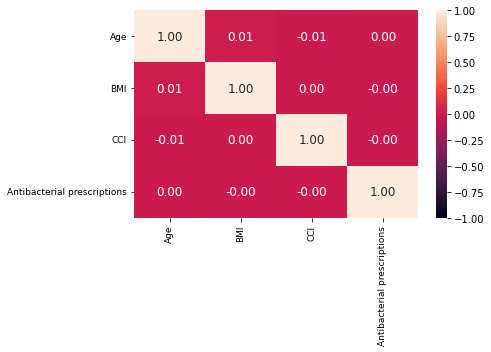

In [34]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_uti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_uti/corr_uti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [35]:
data_uti = data_uti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'uti_ab_date', 'ab_type_cat', 'incdt_uti_date', 'date', 'period',
                                   'event_uti_admitted', 'duration_uti_admitted'
                                    ]]

In [36]:
#incident and prevalent infection 
data_uti_incdt = data_uti[data_uti['incdt_uti_date'] == 0]
data_uti_prevl = data_uti[data_uti['incdt_uti_date'] == 1]
#switch variable uti_ab_date into a binary variable
data_uti_incdt[['uti_ab_date']] = data_uti_incdt[['uti_ab_date']].where(data_uti_incdt[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)
data_uti_prevl[['uti_ab_date']] = data_uti_prevl[['uti_ab_date']].where(data_uti_prevl[['uti_ab_date']].isnull(), 1).fillna(0).astype(int)

# #incident and prevalent infection stratified by sex categories
# data_uti_incdt_males = data_uti_incdt[data_uti_incdt['sex'] == 'male']
# data_uti_incdt_females = data_uti_incdt[data_uti_incdt['sex'] == 'female']
# data_uti_prevl_males = data_uti_prevl[data_uti_prevl['sex'] == 'male']
# data_uti_prevl_females = data_uti_prevl[data_uti_prevl['sex'] == 'female']

# #incident and prevalent infection stratified by age categories
# data_uti_incdt_15_24 = data_uti_incdt[data_uti_incdt['age_cat'] == '15_24']
# data_uti_incdt_25_34 = data_uti_incdt[data_uti_incdt['age_cat'] == '25_34']
# data_uti_incdt_35_44 = data_uti_incdt[data_uti_incdt['age_cat'] == '35_44']
# data_uti_incdt_45_54 = data_uti_incdt[data_uti_incdt['age_cat'] == '45_54']
# data_uti_incdt_55_64 = data_uti_incdt[data_uti_incdt['age_cat'] == '55_64']
# data_uti_incdt_65_74 = data_uti_incdt[data_uti_incdt['age_cat'] == '65_74']
# data_uti_incdt_75_more = data_uti_incdt[data_uti_incdt['age_cat'] == '75_more']
# data_uti_prevl_15_24 = data_uti_prevl[data_uti_prevl['age_cat'] == '15_24']
# data_uti_prevl_25_34 = data_uti_prevl[data_uti_prevl['age_cat'] == '25_34']
# data_uti_prevl_35_44 = data_uti_prevl[data_uti_prevl['age_cat'] == '35_44']
# data_uti_prevl_45_54 = data_uti_prevl[data_uti_prevl['age_cat'] == '45_54']
# data_uti_prevl_55_64 = data_uti_prevl[data_uti_prevl['age_cat'] == '55_64']
# data_uti_prevl_65_74 = data_uti_prevl[data_uti_prevl['age_cat'] == '65_74']
# data_uti_prevl_75_more = data_uti_prevl[data_uti_prevl['age_cat'] == '75_more']

# #incident and prevalent infection stratified by time period categories
# data_uti_incdt_prepandemic = data_uti_incdt[data_uti_incdt['date'] <= '2019-12']
# data_uti_incdt_during_pandemic = data_uti_incdt[(data_uti_incdt['date'] >= '2020-03') & (data_uti_incdt['date']<= '2021-03')]
# data_uti_incdt_post_2nd_lockdown = data_uti_incdt[data_uti_incdt['date'] <= '2021-04']
# data_uti_prevl_prepandemic = data_uti_prevl[data_uti_prevl['date'] <= '2019-12']
# data_uti_prevl_during_pandemic = data_uti_prevl[(data_uti_prevl['date'] >= '2020-03') & (data_uti_prevl['date']<= '2021-03')]
# data_uti_prevl_post_2nd_lockdown = data_uti_prevl[data_uti_prevl['date'] <= '2021-04']

# # no antibiotics and incident hospital admission
# data_uti_no_abs_incdt = data_uti[data_uti['uti_ab_date'].isnull()]
# data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# # with antibiotics and incident hospital admission
# data_uti_abs_incdt = data_uti[data_uti['uti_ab_date'].notnull()]
# data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# # no antibiotics and prevalent hospital admission
# data_uti_no_abs_prevl = data_uti[data_uti['uti_ab_date'].isnull()]
# data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# # with antibiotics and prevalent hospital admission
# data_uti_abs_prevl = data_uti[data_uti['uti_ab_date'].notnull()]
# data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

In [37]:
#store data for plotting hosp admission counts and percentages
%store data_uti
# save data
data_uti.to_csv('../output/hospitalisation_prediction_uti/data_uti.csv')

Stored 'data_uti' (DataFrame)


## 5- cox modelling for hospital admissions

In [38]:
#build cox models 
data_uti_incdt_enc = cox_data_prep(data_uti_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit', 'uti_ab_date'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'incdt', data_uti_incdt_enc)

#make summary table of cases
make_summary_table_cases('uti', 'incdt', data_uti_incdt)

#build cox model
cph, data_uti_incdt_dev, data_uti_incdt_val = cox_model_abs_build('uti', 'incdt', data_uti_incdt)

#calculate c-statistics
cox_output(cph, 'uti', 'incdt', data_uti_incdt_dev, data_uti_incdt_val, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')

<lifelines.CoxPHFitter: fitted with 120759 total observations, 119909 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 120759
number of events observed = 850
   partial log-likelihood = -9922.67
         time fit was run = 2023-05-26 17:49:20 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]            0.01       1.01       0.10            -0.19             0.21                 0.82                 1.24
CCI_cat[T.medium]         0.11       1.12       0.11            -0.11             0.33                 0.89                 1.39
CCI_cat[T.high]           0.13       1.14       0.13            -0.13             0.39                 0.88                 1.48
CCI_cat[T.very_high]     -0.00       1.00       0.12            -0.24             0.24                 0.79                 1.27
age_cat[T.25_34]          0.02       1.02       0.12            -0.21             0.26                 0.81                 1.29
age_cat[T.35_44]         -0.08       0.92       0.12            -0.32             0.16                 0.73                 1.17
age_cat[T.45_54]         -0.21       0.81       0.13            -0.46             0.04                 0.63                 1.04
age_cat[T.55_64]         -0.32       0.72       0.13            -0.58            -0.06                 0.56                 0.94
age_cat[T.65_74]         -0.28       0.76       0.13            -0.53            -0.02                 0.59                 0.98
age_cat[T.75_more]       -0.15       0.86       0.12            -0.39             0.10                 0.68                 1.10
antibacterial_brit       -0.01       0.99       0.02            -0.05             0.04                 0.95                 1.04
bmi_cat[T.obese]          0.23       1.25       0.14            -0.05             0.50                 0.95                 1.65
bmi_cat[T.overweight]     0.33       1.39       0.16             0.01             0.65                 1.01                 1.91
bmi_cat[T.underweight]    0.13       1.14       0.24            -0.34             0.60                 0.71                 1.81
bmi_cat[T.unknown]        0.16       1.17       0.15            -0.13             0.45                 0.88                 1.57
ethnicity[T.other]       -0.29       0.75       0.18            -0.64             0.06                 0.53                 1.06
ethnicity[T.unknown]     -0.20       0.82       0.14            -0.46             0.07                 0.63                 1.07
ethnicity[T.white]       -0.13       0.87       0.12            -0.38             0.11                 0.69                 1.12
flu_vaccine[T.yes]        0.14       1.15       0.11            -0.07             0.35                 0.93                 1.42
imd[T.medium]             0.08       1.08       0.11            -0.14             0.29                 0.87                 1.34
imd[T.unaffluent]        -0.03       0.97       0.11            -0.25             0.19                 0.78                 1.21
imd[T.unknown]           -0.25       0.78       0.19            -0.63             0.13                 0.54                 1.13
imd[T.very_affluent]      0.10       1.10       0.11            -0.12             0.31                 0.89                 1.37
imd[T.very_unaffluent]    0.01       1.01       0.11            -0.21             0.23                 0.81                 1.25
region[T.east_midlands]   0.05       1.05       0.14            -0.24             0.33                 0.79                 1.39
region[T.london]         -0.16       0.85       0.13            -0.42             0.09                 0.66             

13305


In [39]:
#build cox models 
data_uti_prevl_enc = cox_data_prep(data_uti_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period'], ['antibacterial_brit', 'uti_ab_date'], ['event_uti_admitted', 'duration_uti_admitted'])

#make summary table
make_summary_table('uti', 'prevl', data_uti_prevl_enc)

#make summary table of cases
make_summary_table_cases('uti', 'prevl', data_uti_prevl)

#build cox model
cph, data_uti_prevl_dev, data_uti_prevl_val = cox_model_abs_build('uti', 'prevl', data_uti_prevl)
    
#calculate c-statistics
cox_output(cph, 'uti', 'prevl', data_uti_prevl_dev, data_uti_prevl_val, 'event_uti_admitted', 'duration_uti_admitted', '../output/hospitalisation_prediction_uti/')

<lifelines.CoxPHFitter: fitted with 13503 total observations, 13404 right-censored observations>
             duration col = 'duration_uti_admitted'
                event col = 'event_uti_admitted'
      baseline estimation = breslow
   number of observations = 13503
number of events observed = 99
   partial log-likelihood = -927.69
         time fit was run = 2023-05-26 17:49:26 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
CCI_cat[T.low]           -0.05       0.96       0.30            -0.63             0.54                 0.53                 1.71
CCI_cat[T.medium]        -0.09       0.92       0.33            -0.73             0.56                 0.48                 1.76
CCI_cat[T.high]          -0.22       0.80       0.41            -1.03             0.59                 0.36                 1.80
CCI_cat[T.very_high]      0.05       1.06       0.34            -0.61             0.72                 0.54                 2.05
age_cat[T.25_34]          0.59       1.81       0.42            -0.23             1.41                 0.80                 4.09
age_cat[T.35_44]          0.55       1.73       0.42            -0.28             1.38                 0.76                 3.96
age_cat[T.45_54]          0.58       1.78       0.42            -0.24             1.39                 0.79                 4.03
age_cat[T.55_64]          0.21       1.24       0.45            -0.67             1.09                 0.51                 2.99
age_cat[T.65_74]          0.54       1.71       0.42            -0.29             1.36                 0.75                 3.91
age_cat[T.75_more]        0.62       1.86       0.41            -0.19             1.43                 0.83                 4.18
antibacterial_brit       -0.11       0.90       0.07            -0.25             0.04                 0.78                 1.04
bmi_cat[T.obese]         -0.34       0.71       0.33            -1.00             0.31                 0.37                 1.36
bmi_cat[T.overweight]    -0.18       0.84       0.41            -0.98             0.63                 0.37                 1.87
bmi_cat[T.underweight]   -0.12       0.88       0.58            -1.27             1.02                 0.28                 2.78
bmi_cat[T.unknown]       -0.49       0.62       0.37            -1.22             0.25                 0.30                 1.28
ethnicity[T.other]       -0.11       0.90       0.61            -1.30             1.08                 0.27                 2.95
ethnicity[T.unknown]      0.42       1.51       0.45            -0.46             1.30                 0.63                 3.65
ethnicity[T.white]        0.24       1.27       0.43            -0.60             1.08                 0.55                 2.95
flu_vaccine[T.yes]       -0.02       0.98       0.33            -0.68             0.63                 0.51                 1.88
imd[T.medium]            -0.12       0.88       0.32            -0.75             0.50                 0.47                 1.64
imd[T.unaffluent]         0.06       1.06       0.30            -0.53             0.65                 0.59                 1.92
imd[T.unknown]            0.06       1.06       0.46            -0.85             0.97                 0.43                 2.63
imd[T.very_affluent]     -0.10       0.90       0.32            -0.72             0.52                 0.49                 1.68
imd[T.very_unaffluent]   -0.67       0.51       0.37            -1.40             0.06                 0.25                 1.06
region[T.east_midlands]  -0.20       0.82       0.44            -1.07             0.67                 0.34                 1.95
region[T.london]         -0.16       0.85       0.37            -0.89             0.56                 0.41                 1

13296


## 6- Logistic modelling for prescribing antibiotic

### 5-1- incident uti

LR coefficients:
                            lr_coef
bins_(0.0127, 0.0437]    -1.428863
bins_(0.0102, 0.0127]    -1.849155
bins_(0.00867, 0.0102]   -2.038818
bins_(0.00752, 0.00867]  -2.122739
bins_(0.00654, 0.00752]  -2.287376
bins_(0.00569, 0.00654]  -2.398257
bins_(0.00487, 0.00569]  -2.491835
bins_(0.00405, 0.00487]  -2.564414
bins_(0.00312, 0.00405]  -2.675654
bins_(-0.00037, 0.00312] -2.952839

RF parameters after grid search: RandomForestClassifier(max_depth=25, max_leaf_nodes=50, n_estimators=500)

RF feature importance:
                            rf_coef
bins_(0.0127, 0.0437]     0.551882
bins_(-0.00037, 0.00312]  0.124826
bins_(0.0102, 0.0127]     0.106592
bins_(0.00312, 0.00405]   0.058538
bins_(0.00867, 0.0102]    0.039584
bins_(0.00405, 0.00487]   0.035917
bins_(0.00487, 0.00569]   0.025864
bins_(0.00752, 0.00867]   0.023647
bins_(0.00569, 0.00654]   0.018595
bins_(0.00654, 0.00752]   0.014555

LR AUROC with development and validation data: 0.62 and 0.61
RF AUROC with dev

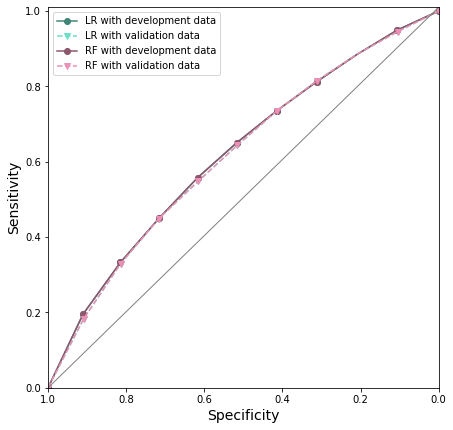

AttributeError: 'int' object has no attribute 'round'

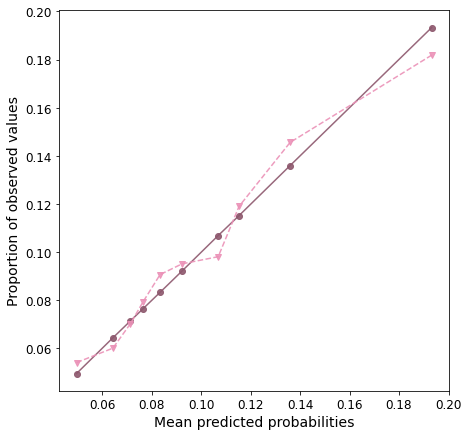

In [40]:
#build lr and rf models with additional predictor of risk deciles
lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val, data_uti_incdt_dev_y, data_uti_incdt_val_y = build_lr_rf_model_with_risk_deciles('uti', 'incdt', data_uti_incdt_dev, data_uti_incdt_val, cph)
#evaluate lr and rf models
lr_rf_roc_ci('uti', 'incdt', data_uti_incdt_dev_y, data_uti_incdt_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
#lr and rf calibrations
lr_rf_calibration('uti', 'incdt', data_uti_incdt_dev_y, data_uti_incdt_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)

### 5-2- prevalent uti

LR coefficients:
                                           lr_coef
bins_(0.0126, 0.0437]                   -1.368807
bins_(0.0101, 0.0126]                   -1.852705
bins_(0.00867, 0.0101]                  -2.094530
bins_(0.00748, 0.00867]                 -2.102141
bins_(0.00654, 0.00748]                 -2.309121
bins_(0.00569, 0.00654]                 -2.453258
bins_(0.00485, 0.00569]                 -2.558585
bins_(0.00404, 0.00485]                 -2.592393
bins_(0.00313, 0.00404]                 -2.738477
bins_(-0.00030100000000000005, 0.00313] -2.891935

LR AUROC with development and validation data: 0.62 and 0.60


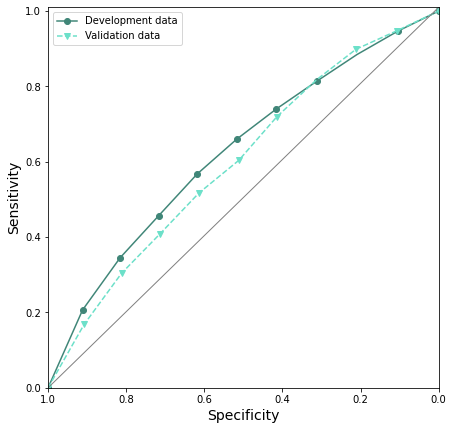

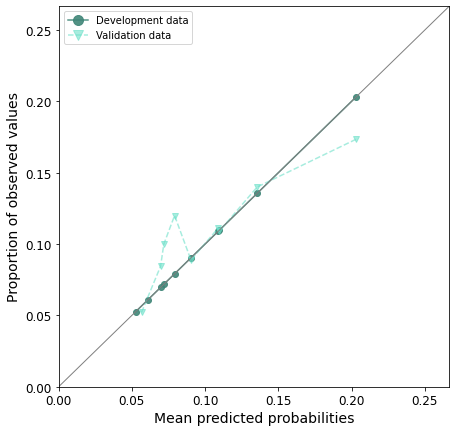

In [ ]:
#build lr and rf models with additional predictor of risk deciles
lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val, data_uti_prevl_dev_y, data_uti_prevl_val_y = build_lr_rf_model_with_risk_deciles('uti', 'prevl', data_uti_prevl_dev, data_uti_prevl_val, cph)
#evaluate lr and rf models
lr_rf_roc_ci('uti', 'prevl', data_uti_prevl_dev_y, data_uti_prevl_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)
#lr and rf calibrations
lr_rf_calibration('uti', 'prevl', data_uti_prevl_dev_y, data_uti_prevl_val_y, lr_risk_pred_dev, lr_risk_pred_val, rf_risk_pred_dev, rf_risk_pred_val)